# Model Name: Qwen/Qwen2.5-VL-7B-Instruct
# Dataset: New Sloped Roofs

In [4]:
!nvidia-smi

Sat Mar 22 23:23:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:01:00.0 Off |                    0 |
| N/A   29C    P0             64W /  500W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Tutorial and details
https://nodeshift.com/blog/how-to-install-qwen2-5-vl-7b-instruct-locally
#### GPU Requirements
1. Minimum: 24GB VRAM (with quantization)2. 
Recommended: 48GB+ VRAM for full performance (e.g., NVIDIA A6000 or A100
3. 
Optimal: 80GB VRAM for long-context, video-heavy tasks (e.g., NVIDIA H10

#### CPU Requirements
1. Text-based tasks: 16-core CPU is sufficient.2. 
Multimodal (image/video) tasks: 32+ cores recommended for fast preprocessing

#### RAM Requirements
1. Minimum: 32GB RAM for smooth operation with images.2. 
Recommended: 64GB RAM for vision-heavy tasks.3. 
Optimal: 128GB+ RAM for handling long video

#### Disk Space & Storage
1. Minimum: 50GB free space for model weights and temporary files.2. 
Recommended: 1TB NVMe SSD for faster model loading and caching.3. 
High-speed SSD storage is crucial for video-heavy taskss..0)

### Install PyTorch with GPU Support

In [6]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121


### Verify PyTorch Installation

In [7]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected.")

PyTorch Version: 2.5.1+cu124
CUDA Available: True
GPU Name: NVIDIA A100-SXM4-80GB


### Install Dependencies

In [8]:
!pip install git+https://github.com/huggingface/transformers accelerate
!pip install qwen-vl-utils[decord]==0.0.8

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/huggingface/transformers to /tmp/gjenni-tmpdir-Hbjvnq/pip-req-build-wzlw_1iv
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/gjenni-tmpdir-Hbjvnq/pip-req-build-wzlw_1iv
  Resolved https://github.com/huggingface/transformers to commit c9d1e5238a752813ba91a8751a638a09b5efbb73
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.51.0.dev0-py3-none-any.whl size=11004959 sha256=ca6f3380eaa76cc868452b673464631c09ea4fc3781c5cfb8ede7ccc960eaa07
  Stored in directory: /tmp/gjenni-tmpdir-Hbjvnq/pip-ephem-wheel-cache-7vhtt8ih/wheels/49/a7/50/c9fdabbf10e51bb1256adb0c1a587fedd7184f5bad28d47fe3
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transfo

### Load the Model and Processor

In [5]:
import pandas as pd
import os

In [1]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

# Load the model on the GPU
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype=torch.float16, device_map="auto"
)

# Load the processor
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

print("Model and Processor Loaded Successfully!")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model and Processor Loaded Successfully!


## Evaluation cases
Both cases will be evaluated based on roof features and types for the various prompts.

1. Case 1 (System Role: Helpful Assistant)
2. Case 2 (System Role: Expert)
   
Based on the original ground truth values

P1: Skylight

P2: Vents/ Chimneys

P3: Hipped Roof

P4: Mixed (Hipped L)

P5: Gable Roof

P6: Mixed (Gable + Hipped)


## Case 1

### Image Inference for Testing

In [3]:
# Load your image
image_path = "/mnt/data/oe215/env/guna/Sloped_249/3587751.png"


# Prepare input
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image_path},
            {"type": "text", "text": "Is the roof of the building of hipped type?"},
        ],
    }
]
# Convert input into the required format
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)

# Tokenize and move to GPU
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
).to("cuda")

# Generate output
generated_ids = model.generate(**inputs, max_new_tokens=128)

# Decode and print result
output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
print("Generated Output:", output_text)

Generated Output: ['system\nYou are a helpful assistant.\nuser\nIs the roof of the building of hipped type?\nassistant\nNo, the roof of the building in the image is not of a hipped type. A hipped roof has four sloped sides that meet at the top, forming a hip. The roof in the image appears to be a gabled roof, which has two sloped sides that meet at the top and form a peak.']


### Load GTs and Images and Inference Function Definition

In [6]:
# Load Excel and image folder
excel_path = "/mnt/data/oe215/env/guna/sloped_roof_249.xlsx"
image_folder = "/mnt/data/oe215/env/guna/Sloped_249"
df = pd.read_excel(excel_path)
df['FS_DE_ID'] = df['FS_DE_ID'].astype(str)

def run_qwen_inference(image_path, prompt):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_path},
                {"type": "text", "text": prompt},
            ],
        }
    ]
    
    # Apply chat template
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    # Vision input
    image_inputs, video_inputs = process_vision_info(messages)

    # Tokenize
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to("cuda")

    # Generate only the new tokens
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            eos_token_id=processor.tokenizer.eos_token_id,
            pad_token_id=processor.tokenizer.pad_token_id
        )

    # Decode only the newly generated part
    generated_text = processor.batch_decode(
        generated_ids[:, inputs['input_ids'].shape[1]:],  # ⬅️ Skip the prompt tokens
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )[0]
    
    return generated_text


### Run Inference for Skylights

In [5]:
from tqdm import tqdm

prompt = "Does the roof of the building have any skylights? Answer with only 'Yes' or 'No' by properly analyzing the image?"
skylight_results = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if os.path.exists(image_path):
        try:
            response = run_qwen_inference(image_path, prompt)
        except Exception as e:
            response = f"Error: {e}"
    else:
        response = "Image not found"

    skylight_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Skylights"],
        "Prediction": response
    })

skylight_df = pd.DataFrame(skylight_results)


  0%|          | 0/249 [00:00<?, ?it/s]/mnt/home/gjenni/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 249/249 [00:41<00:00,  6.04it/s]


### Evaluate Predictions + Export CSV and Confusion Matrix

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Directories to save outputs
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].str.strip().str.lower().str.extract(r'(yes|no)')[0].map({"yes": "Y", "no": "N"})
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save CSV
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")


In [7]:
evaluate_and_save_binary(skylight_df, "Skylights")


=== SKYLIGHTS ===
Accuracy: 0.6265060240963856
              precision    recall  f1-score   support

          No       0.72      0.77      0.75       177
         Yes       0.32      0.26      0.29        72

    accuracy                           0.63       249
   macro avg       0.52      0.52      0.52       249
weighted avg       0.61      0.63      0.61       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/skylights_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/skylights_confusion_matrix.png


### Dormer Windows inference


In [7]:
from tqdm import tqdm

# 🧠 Updated prompt for Dormer Windows
prompt = "Does the roof of the building have any dormer windows? Answer with only 'Yes' or 'No' by properly analyzing the image."

dormer_results = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if os.path.exists(image_path):
        try:
            response = run_qwen_inference(image_path, prompt)
        except Exception as e:
            response = f"Error: {e}"
    else:
        response = "Image not found"

    dormer_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Dormer Windows"],
        "Prediction": response
    })

dormer_df = pd.DataFrame(dormer_results)


  0%|          | 0/249 [00:00<?, ?it/s]/mnt/home/gjenni/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 249/249 [00:40<00:00,  6.17it/s]


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Directories to save outputs
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    # Normalize predictions
    df["Prediction_Normalized"] = df[pred_col].str.strip().str.lower().str.extract(r'(yes|no)')[0].map({"yes": "Y", "no": "N"})

    # Drop any rows with missing prediction or ground truth
    before = len(df)
    eval_df = df.dropna(subset=["Prediction_Normalized", gt_col]).copy()
    dropped = before - len(eval_df)

    if dropped > 0:
        print(f"⚠️ Dropped {dropped} row(s) due to missing values in prediction or ground truth.")

    # Binary conversion
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save to CSV
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")


In [9]:
evaluate_and_save_binary(dormer_df, "Dormer Windows")


=== DORMER WINDOWS ===


/mnt/home/gjenni/.local/lib/python3.12/site-packages/sklearn/utils/_array_api.py:390: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

### Vents Inference

In [24]:
from tqdm import tqdm


prompt = "Does the roof of the building have any vents or chimneys? Answer with only 'Yes' or 'No' by properly analyzing the image?"

vents_results = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if os.path.exists(image_path):
        try:
            response = run_qwen_inference(image_path, prompt)
        except Exception as e:
            response = f"Error: {e}"
    else:
        response = "Image not found"

    vents_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Vents/Chimneys"],
        "Prediction": response
    })

vents_df = pd.DataFrame(vents_results)


  0%|          | 0/249 [00:00<?, ?it/s]/mnt/home/gjenni/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 249/249 [00:40<00:00,  6.14it/s]


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Directories to save outputs
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].str.strip().str.lower().str.extract(r'(yes|no)')[0].map({"yes": "Y", "no": "N"})
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save CSV
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")


In [26]:
evaluate_and_save_binary(vents_df, "Vents")


=== VENTS ===
Accuracy: 0.321285140562249
              precision    recall  f1-score   support

          No       0.09      0.94      0.16        17
         Yes       0.98      0.28      0.43       232

    accuracy                           0.32       249
   macro avg       0.54      0.61      0.30       249
weighted avg       0.92      0.32      0.41       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/vents_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/vents_confusion_matrix.png


### Run Inference for Hipped

In [54]:
from tqdm import tqdm

prompt = "Is the roof of the building of hipped type? Answer with only 'Yes' or 'No' by properly analyzing the image?"

hipped_results = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if os.path.exists(image_path):
        try:
            response = run_qwen_inference(image_path, prompt)
        except Exception as e:
            response = f"Error: {e}"
    else:
        response = "Image not found"

    hipped_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Hipped"],
        "Prediction": response
    })

hipped_df = pd.DataFrame(hipped_results)


100%|██████████| 249/249 [00:40<00:00,  6.19it/s]


### Hipped Evaluate Predictions + Export CSV and Confusion Matrix

In [57]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Save directories
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

# ✅ Improved Yes/No extractor
def extract_yes_no(text):
    if not isinstance(text, str):
        return None
    text = text.strip().lower()
    if 'yes' in text and 'no' not in text:
        return 'Y'
    elif 'no' in text and 'yes' not in text:
        return 'N'
    return None  # ambiguous or both present

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].apply(extract_yes_no)

    # Filter rows where prediction could be extracted
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()

    if eval_df.empty:
        print(f"\n🚫 Skipping '{name}' — no valid yes/no predictions found.")
        return

    # Convert Y/N to 1/0
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save predictions
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")



In [58]:
evaluate_and_save_binary(hipped_df, "Hipped")


=== HIPPED ===
Accuracy: 0.678714859437751
              precision    recall  f1-score   support

          No       0.79      0.70      0.74       164
         Yes       0.52      0.65      0.58        85

    accuracy                           0.68       249
   macro avg       0.66      0.67      0.66       249
weighted avg       0.70      0.68      0.69       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/hipped_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/hipped_confusion_matrix.png


### Run Inference for Mixed Hipped

In [7]:
from tqdm import tqdm

# 🔄 Prompt tailored for mixed L-shaped hipped roof detection
prompt = "Is the roof of the building of Mixed (Hipped L) type? Answer with only 'Yes' or 'No' by properly analyzing the image?"

mixed_hipped_results = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if os.path.exists(image_path):
        try:
            response = run_qwen_inference(image_path, prompt)
        except Exception as e:
            response = f"Error: {e}"
    else:
        response = "Image not found"

    mixed_hipped_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Mixed (Hipped L)"],
        "Prediction": response
    })

mixed_hipped_df = pd.DataFrame(mixed_hipped_results)


  0%|          | 0/249 [00:00<?, ?it/s]/mnt/home/gjenni/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 249/249 [00:40<00:00,  6.20it/s]


### Mixed (Hipped L) Evaluate Predictions + Export CSV and Confusion Matrix

In [8]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Save directories
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

# ✅ Improved Yes/No extractor
def extract_yes_no(text):
    if not isinstance(text, str):
        return None
    text = text.strip().lower()
    if 'yes' in text and 'no' not in text:
        return 'Y'
    elif 'no' in text and 'yes' not in text:
        return 'N'
    return None  # ambiguous or both present

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].apply(extract_yes_no)

    # Filter rows where prediction could be extracted
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()

    if eval_df.empty:
        print(f"\n🚫 Skipping '{name}' — no valid yes/no predictions found.")
        return

    # Convert Y/N to 1/0
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save predictions
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")



In [9]:
evaluate_and_save_binary(mixed_hipped_df, "Mixed (Hipped L)")


=== MIXED (HIPPED L) ===
Accuracy: 0.6626506024096386
              precision    recall  f1-score   support

          No       0.88      0.67      0.76       199
         Yes       0.33      0.64      0.43        50

    accuracy                           0.66       249
   macro avg       0.60      0.65      0.60       249
weighted avg       0.77      0.66      0.69       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/mixed_(hipped_l)_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/mixed_(hipped_l)_confusion_matrix.png


### Run Inference for Gable

In [16]:
from tqdm import tqdm

prompt = "Does the roof of the building have two sloping sides that form a triangular wall on both ends (gable roof)? Answer only with 'yes' or 'no'."

gable_results = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if os.path.exists(image_path):
        try:
            response = run_qwen_inference(image_path, prompt)
        except Exception as e:
            response = f"Error: {e}"
    else:
        response = "Image not found"

    gable_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Gable"],
        "Prediction": response
    })

gable_df = pd.DataFrame(gable_results)


  0%|          | 0/249 [00:00<?, ?it/s]/mnt/home/gjenni/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 249/249 [00:40<00:00,  6.19it/s]


### Gable Evaluate Predictions + Export CSV and Confusion Matrix

In [17]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Save directories
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

# ✅ Improved Yes/No extractor
def extract_yes_no(text):
    if not isinstance(text, str):
        return None
    text = text.strip().lower()
    if 'yes' in text and 'no' not in text:
        return 'Y'
    elif 'no' in text and 'yes' not in text:
        return 'N'
    return None  # ambiguous or both present

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].apply(extract_yes_no)

    # Filter rows where prediction could be extracted
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()

    if eval_df.empty:
        print(f"\n🚫 Skipping '{name}' — no valid yes/no predictions found.")
        return

    # Convert Y/N to 1/0
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save predictions
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")



In [18]:
evaluate_and_save_binary(gable_df, "Gable")



=== GABLE ===
Accuracy: 0.3815261044176707
              precision    recall  f1-score   support

          No       0.36      0.03      0.05       151
         Yes       0.38      0.93      0.54        98

    accuracy                           0.38       249
   macro avg       0.37      0.48      0.30       249
weighted avg       0.37      0.38      0.24       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/gable_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/gable_confusion_matrix.png


### Run Inference for Mixed(Gable+Hipped)

In [19]:
from tqdm import tqdm

prompt = "Does the roof of the building combine both gable and hipped sections, such as a mix of triangular gable ends and hips on other sides? Answer only 'yes' or 'no'."

mixed_gable_results = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if os.path.exists(image_path):
        try:
            response = run_qwen_inference(image_path, prompt)
        except Exception as e:
            response = f"Error: {e}"
    else:
        response = "Image not found"

    mixed_gable_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Mixed(Gable+Hipped)"],
        "Prediction": response
    })

mixed_gable_df = pd.DataFrame(mixed_gable_results)


  0%|          | 0/249 [00:00<?, ?it/s]/mnt/home/gjenni/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 249/249 [00:40<00:00,  6.19it/s]


In [20]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Save directories
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

# ✅ Improved Yes/No extractor
def extract_yes_no(text):
    if not isinstance(text, str):
        return None
    text = text.strip().lower()
    if 'yes' in text and 'no' not in text:
        return 'Y'
    elif 'no' in text and 'yes' not in text:
        return 'N'
    return None  # ambiguous or both present

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].apply(extract_yes_no)

    # Filter rows where prediction could be extracted
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()

    if eval_df.empty:
        print(f"\n🚫 Skipping '{name}' — no valid yes/no predictions found.")
        return

    # Convert Y/N to 1/0
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save predictions
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")



In [21]:
evaluate_and_save_binary(mixed_gable_df, "Mixed(Gable+Hipped)")



=== MIXED(GABLE+HIPPED) ===
Accuracy: 0.10040160642570281
              precision    recall  f1-score   support

          No       1.00      0.04      0.07       233
         Yes       0.07      1.00      0.12        16

    accuracy                           0.10       249
   macro avg       0.53      0.52      0.10       249
weighted avg       0.94      0.10      0.08       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/mixed(gable+hipped)_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/mixed(gable+hipped)_confusion_matrix.png


## Living Space

In [27]:
from tqdm import tqdm

prompt = "Analyze the image and determine if there is living space under the roof of the building. Consider roof features like gabled or hipped roof, dormer windows, skylights, and overall roof volume. Answer 'Yes' if the roof has dormer windows or skylights or gabled, otherwise answer 'No.'"


living_results = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if os.path.exists(image_path):
        try:
            response = run_qwen_inference(image_path, prompt)
        except Exception as e:
            response = f"Error: {e}"
    else:
        response = "Image not found"

    living_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Presence of living space"],
        "Prediction": response
    })

living_df = pd.DataFrame(living_results)


  0%|          | 0/249 [00:00<?, ?it/s]/mnt/home/gjenni/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 249/249 [05:26<00:00,  1.31s/it]


In [28]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Save directories
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

# ✅ Improved Yes/No extractor
def extract_yes_no(text):
    if not isinstance(text, str):
        return None
    text = text.strip().lower()
    if 'yes' in text and 'no' not in text:
        return 'Y'
    elif 'no' in text and 'yes' not in text:
        return 'N'
    return None  # ambiguous or both present

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].apply(extract_yes_no)

    # Filter rows where prediction could be extracted
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()

    if eval_df.empty:
        print(f"\n🚫 Skipping '{name}' — no valid yes/no predictions found.")
        return

    # Convert Y/N to 1/0
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save predictions
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")



In [29]:
evaluate_and_save_binary(living_df, "Living Space")


=== LIVING SPACE ===
Accuracy: 0.3614457831325301
              precision    recall  f1-score   support

          No       0.33      0.93      0.49        83
         Yes       0.68      0.08      0.14       166

    accuracy                           0.36       249
   macro avg       0.51      0.50      0.32       249
weighted avg       0.57      0.36      0.26       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/living_space_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/living_space_confusion_matrix.png


## New Combined Evaluation

### Combining Hipped and Mixed Hipped

In [22]:
import pandas as pd

# Load your Excel file (already in JupyterLab directory)
df = pd.read_excel("sloped_roof_249.xlsx")

# Combine 'Hipped' and 'Mixed (Hipped L)' into 'Combined_Hipped'
df['Combined_Hipped'] = df.apply(
    lambda row: 'Y' if row.get('Hipped') == 'Y' or row.get('Mixed (Hipped L)') == 'Y' else 'N',
    axis=1
)

# Combine 'Gable' and 'Mixed(Gable+Hipped)' into 'Combined_Gable'
df['Combined_Gable'] = df.apply(
    lambda row: 'Y' if row.get('Gable') == 'Y' or row.get('Mixed(Gable+Hipped)') == 'Y' else 'N',
    axis=1
)

# Save to new CSV
df[['FS_DE_ID', 'Combined_Hipped', 'Combined_Gable']].to_csv("combined_hipped_gable_labels.csv", index=False)

print("✅ Combined labels saved as 'combined_hipped_gable_labels.csv'")


✅ Combined labels saved as 'combined_hipped_gable_labels.csv'


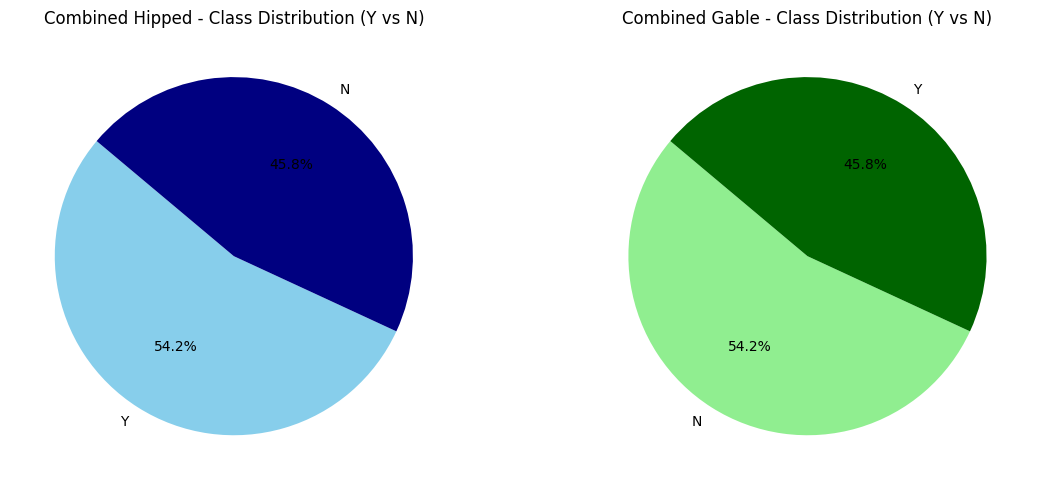

In [24]:
import matplotlib.pyplot as plt

# Pie chart for Combined_Hipped
hipped_counts = df['Combined_Hipped'].value_counts()

plt.figure(figsize=(12, 5))

# Combined Hipped Pie Chart
plt.subplot(1, 2, 1)
plt.pie(
    hipped_counts,
    labels=hipped_counts.index,
    autopct='%1.1f%%',
    colors=['skyblue', 'navy'],
    startangle=140
)
plt.title('Combined Hipped - Class Distribution (Y vs N)')

# Pie chart for Combined_Gable
gable_counts = df['Combined_Gable'].value_counts()

plt.subplot(1, 2, 2)
plt.pie(
    gable_counts,
    labels=gable_counts.index,
    autopct='%1.1f%%',
    colors=['lightgreen', 'darkgreen'],
    startangle=140
)
plt.title('Combined Gable - Class Distribution (Y vs N)')

plt.tight_layout()
plt.show()


### Loading the combined labels of hipped roof

In [3]:
import pandas as pd
import os

# Load the combined CSV file
combined_path = "combined_hipped_gable_labels.csv"
df_combined = pd.read_csv(combined_path)

# Confirm FS_DE_ID is string type
df_combined['FS_DE_ID'] = df_combined['FS_DE_ID'].astype(str)


### Inference for combined hipped

In [29]:
from tqdm import tqdm

# Prompt (use your best-performing one)
prompt = "Is the roof of the building of hipped type? Answer with only 'Yes' or 'No' by properly analyzing the image?"

combined_hipped_results = []

for idx, row in tqdm(df_combined.iterrows(), total=len(df_combined)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if os.path.exists(image_path):
        try:
            response = run_qwen_inference(image_path, prompt)
        except Exception as e:
            response = f"Error: {e}"
    else:
        response = "Image not found"

    combined_hipped_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Combined_Hipped"],
        "Prediction": response
    })

combined_hipped_df = pd.DataFrame(combined_hipped_results)


  0%|          | 0/249 [00:00<?, ?it/s]/mnt/home/gjenni/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 249/249 [00:40<00:00,  6.21it/s]


In [30]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Save directories
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

# ✅ Improved Yes/No extractor
def extract_yes_no(text):
    if not isinstance(text, str):
        return None
    text = text.strip().lower()
    if 'yes' in text and 'no' not in text:
        return 'Y'
    elif 'no' in text and 'yes' not in text:
        return 'N'
    return None  # ambiguous or both present

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].apply(extract_yes_no)

    # Filter rows where prediction could be extracted
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()

    if eval_df.empty:
        print(f"\n🚫 Skipping '{name}' — no valid yes/no predictions found.")
        return

    # Convert Y/N to 1/0
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save predictions
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")



In [31]:
evaluate_and_save_binary(combined_hipped_df, "Combined Hipped Roof")


=== COMBINED HIPPED ROOF ===
Accuracy: 0.7188755020080321
              precision    recall  f1-score   support

          No       0.65      0.82      0.73       114
         Yes       0.81      0.63      0.71       135

    accuracy                           0.72       249
   macro avg       0.73      0.73      0.72       249
weighted avg       0.74      0.72      0.72       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/combined_hipped_roof_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/combined_hipped_roof_confusion_matrix.png


### Inference Using Caption + QA Prompt (Hipped Example)

In [6]:
from tqdm import tqdm

caption_prompt = "Describe the roof shape of this building."
qa_prompt_template = "Based on your description, is the roof of hipped type? Answer only 'yes' or 'no'."

caption_then_qa_results = []

for idx, row in tqdm(df_combined.iterrows(), total=len(df_combined)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if not os.path.exists(image_path):
        response = "Image not found"
        caption = None
    else:
        try:
            # Step 1: Get roof description
            caption = run_qwen_inference(image_path, caption_prompt)

            # Step 2: Ask the model to classify based on its own description
            follow_up_messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": caption},
                        {"type": "text", "text": qa_prompt_template}
                    ]
                }
            ]

            follow_up_text = processor.apply_chat_template(
                follow_up_messages, tokenize=False, add_generation_prompt=True
            )

            image_inputs, video_inputs = process_vision_info(follow_up_messages)

            inputs = processor(
                text=[follow_up_text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt"
            ).to("cuda")

            with torch.no_grad():
                generated_ids = model.generate(
                    **inputs,
                    max_new_tokens=64,
                    do_sample=False,
                    eos_token_id=processor.tokenizer.eos_token_id,
                    pad_token_id=processor.tokenizer.pad_token_id
                )

            response = processor.batch_decode(
                generated_ids[:, inputs['input_ids'].shape[1]:],
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True
            )[0]

        except Exception as e:
            caption = None
            response = f"Error: {e}"

    caption_then_qa_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Combined_Hipped"],
        "Caption": caption,
        "Prediction": response
    })

caption_then_qa_df = pd.DataFrame(caption_then_qa_results)


  0%|          | 0/249 [00:00<?, ?it/s]/mnt/home/gjenni/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 249/249 [13:39<00:00,  3.29s/it]


In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Save directories
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

# ✅ Improved Yes/No extractor
def extract_yes_no(text):
    if not isinstance(text, str):
        return None
    text = text.strip().lower()
    if 'yes' in text and 'no' not in text:
        return 'Y'
    elif 'no' in text and 'yes' not in text:
        return 'N'
    return None  # ambiguous or both present

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].apply(extract_yes_no)

    # Filter rows where prediction could be extracted
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()

    if eval_df.empty:
        print(f"\n🚫 Skipping '{name}' — no valid yes/no predictions found.")
        return

    # Convert Y/N to 1/0
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save predictions
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")



In [8]:
evaluate_and_save_binary(caption_then_qa_df, "Combined Hipped Roof (Caption + QA)")



=== COMBINED HIPPED ROOF (CAPTION + QA) ===
Accuracy: 0.4819277108433735
              precision    recall  f1-score   support

          No       0.47      1.00      0.64       114
         Yes       1.00      0.04      0.09       135

    accuracy                           0.48       249
   macro avg       0.73      0.52      0.36       249
weighted avg       0.76      0.48      0.34       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/combined_hipped_roof_(caption_+_qa)_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/combined_hipped_roof_(caption_+_qa)_confusion_matrix.png


### Inference for combined gable

In [50]:
from tqdm import tqdm

# 📢 Updated prompt for gable roofs
prompt = "Is the roof of the building of gabled type? Answer with only 'Yes' or 'No' by properly analyzing the image?"

combined_gable_results = []

for idx, row in tqdm(df_combined.iterrows(), total=len(df_combined)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if os.path.exists(image_path):
        try:
            response = run_qwen_inference(image_path, prompt)
        except Exception as e:
            response = f"Error: {e}"
    else:
        response = "Image not found"

    combined_gable_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Combined_Gable"],
        "Prediction": response
    })

combined_gable_df = pd.DataFrame(combined_gable_results)


  0%|          | 0/249 [00:00<?, ?it/s]/mnt/home/gjenni/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 249/249 [00:40<00:00,  6.19it/s]


In [51]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Save directories
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

# ✅ Improved Yes/No extractor
def extract_yes_no(text):
    if not isinstance(text, str):
        return None
    text = text.strip().lower()
    if 'yes' in text and 'no' not in text:
        return 'Y'
    elif 'no' in text and 'yes' not in text:
        return 'N'
    return None  # ambiguous or both present

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].apply(extract_yes_no)

    # Filter rows where prediction could be extracted
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()

    if eval_df.empty:
        print(f"\n🚫 Skipping '{name}' — no valid yes/no predictions found.")
        return

    # Convert Y/N to 1/0
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save predictions
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")



In [52]:
evaluate_and_save_binary(combined_gable_df, "Combined Gable Roof")



=== COMBINED GABLE ROOF ===
Accuracy: 0.3413654618473896
              precision    recall  f1-score   support

          No       0.31      0.18      0.23       135
         Yes       0.35      0.54      0.43       114

    accuracy                           0.34       249
   macro avg       0.33      0.36      0.33       249
weighted avg       0.33      0.34      0.32       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/combined_gable_roof_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/combined_gable_roof_confusion_matrix.png


### Inference Using Caption + QA Prompt (Gable Example)

In [53]:
from tqdm import tqdm

caption_prompt = "Describe the roof shape of this building."
qa_prompt_template = "Based on your description, is the roof of gable type? Answer only 'yes' or 'no'."

caption_then_qa_results = []

for idx, row in tqdm(df_combined.iterrows(), total=len(df_combined)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if not os.path.exists(image_path):
        response = "Image not found"
        caption = None
    else:
        try:
            # Step 1: Caption
            caption = run_qwen_inference(image_path, caption_prompt)
            
            # Step 2: Feed caption back into the model with a follow-up question
            follow_up_messages = [
                {"role": "user", "content": [
                    {"type": "text", "text": caption},
                    {"type": "text", "text": qa_prompt_template}
                ]}
            ]
            follow_up_text = processor.apply_chat_template(follow_up_messages, tokenize=False, add_generation_prompt=True)
            image_inputs, video_inputs = process_vision_info(follow_up_messages)

            inputs = processor(
                text=[follow_up_text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt"
            ).to("cuda")

            with torch.no_grad():
                generated_ids = model.generate(
                    **inputs,
                    max_new_tokens=64,
                    do_sample=False,
                    eos_token_id=processor.tokenizer.eos_token_id,
                    pad_token_id=processor.tokenizer.pad_token_id
                )

            response = processor.batch_decode(
                generated_ids[:, inputs['input_ids'].shape[1]:],
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True
            )[0]

        except Exception as e:
            caption = None
            response = f"Error: {e}"

    caption_then_qa_results.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Combined_Gable"],
        "Caption": caption,
        "Prediction": response
    })

caption_then_qa_df = pd.DataFrame(caption_then_qa_results)


  0%|          | 0/249 [00:00<?, ?it/s]/mnt/home/gjenni/.local/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 249/249 [13:23<00:00,  3.23s/it]


In [54]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Save directories
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

# ✅ Improved Yes/No extractor
def extract_yes_no(text):
    if not isinstance(text, str):
        return None
    text = text.strip().lower()
    if 'yes' in text and 'no' not in text:
        return 'Y'
    elif 'no' in text and 'yes' not in text:
        return 'N'
    return None  # ambiguous or both present

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].apply(extract_yes_no)

    # Filter rows where prediction could be extracted
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()

    if eval_df.empty:
        print(f"\n🚫 Skipping '{name}' — no valid yes/no predictions found.")
        return

    # Convert Y/N to 1/0
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save predictions
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")



In [55]:
evaluate_and_save_binary(caption_then_qa_df, "Combined Gable Roof (Caption + QA)")



=== COMBINED GABLE ROOF (CAPTION + QA) ===
Accuracy: 0.41767068273092367
              precision    recall  f1-score   support

          No       0.45      0.30      0.36       135
         Yes       0.40      0.55      0.46       114

    accuracy                           0.42       249
   macro avg       0.42      0.43      0.41       249
weighted avg       0.43      0.42      0.41       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/combined_gable_roof_(caption_+_qa)_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/combined_gable_roof_(caption_+_qa)_confusion_matrix.png


## Roles as Expert

In [56]:
def run_qwen_inference(image_path, prompt):
    messages = [
        {
            "role": "system",
            "content": "You are an expert in analyzing geospatial aerial images of residential buildings. Your expertise includes roof classification, roof volume analysis, and determining the utilization of roof spaces for living purposes. Provide detailed, accurate insights based on visual and structural features of roofs."
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_path},
                {"type": "text", "text": prompt},
            ],
        }
    ]
    
    # Apply chat template
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    # Vision input
    image_inputs, video_inputs = process_vision_info(messages)

    # Tokenize
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to("cuda")

    # Generate only the new tokens
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            eos_token_id=processor.tokenizer.eos_token_id,
            pad_token_id=processor.tokenizer.pad_token_id
        )

    # Decode only the newly generated part
    generated_text = processor.batch_decode(
        generated_ids[:, inputs['input_ids'].shape[1]:],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )[0]
    
    return generated_text


In [58]:
from tqdm import tqdm

# Prompt (use your best-performing one)
prompt = "Is the roof of the building of hipped type? Answer with only 'Yes' or 'No' by properly analyzing the image?"

combined_hipped_results_exp = []

for idx, row in tqdm(df_combined.iterrows(), total=len(df_combined)):
    fs_id = row["FS_DE_ID"]
    image_path = os.path.join(image_folder, f"{fs_id}.png")

    if os.path.exists(image_path):
        try:
            response = run_qwen_inference(image_path, prompt)
        except Exception as e:
            response = f"Error: {e}"
    else:
        response = "Image not found"

    combined_hipped_results_exp.append({
        "FS_DE_ID": fs_id,
        "Ground Truth": row["Combined_Hipped"],
        "Prediction": response
    })

combined_hipped_df_exp = pd.DataFrame(combined_hipped_results_exp)


100%|██████████| 249/249 [00:40<00:00,  6.16it/s]


In [59]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Save directories
csv_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions"
cm_output_dir = "/mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix"
os.makedirs(csv_output_dir, exist_ok=True)
os.makedirs(cm_output_dir, exist_ok=True)

# ✅ Improved Yes/No extractor
def extract_yes_no(text):
    if not isinstance(text, str):
        return None
    text = text.strip().lower()
    if 'yes' in text and 'no' not in text:
        return 'Y'
    elif 'no' in text and 'yes' not in text:
        return 'N'
    return None  # ambiguous or both present

def evaluate_and_save_binary(df, name, gt_col="Ground Truth", pred_col="Prediction"):
    df["Prediction_Normalized"] = df[pred_col].apply(extract_yes_no)

    # Filter rows where prediction could be extracted
    eval_df = df.dropna(subset=["Prediction_Normalized"]).copy()

    if eval_df.empty:
        print(f"\n🚫 Skipping '{name}' — no valid yes/no predictions found.")
        return

    # Convert Y/N to 1/0
    eval_df["Ground Truth Binary"] = eval_df[gt_col].map({"Y": 1, "N": 0})
    eval_df["Prediction Binary"] = eval_df["Prediction_Normalized"].map({"Y": 1, "N": 0})

    y_true = eval_df["Ground Truth Binary"]
    y_pred = eval_df["Prediction Binary"]

    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    cm_path = os.path.join(cm_output_dir, f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight")
    plt.close()

    # Save predictions
    export_df = eval_df[["FS_DE_ID", "Ground Truth Binary", "Prediction Binary"]]
    csv_path = os.path.join(csv_output_dir, f"{name.lower().replace(' ', '_')}_predictions.csv")
    export_df.to_csv(csv_path, index=False)

    print(f"✅ Saved to:\n- {csv_path}\n- {cm_path}")



In [60]:
evaluate_and_save_binary(combined_hipped_df_exp, "Combined Hipped Roof Expert")



=== COMBINED HIPPED ROOF EXPERT ===
Accuracy: 0.7068273092369478
              precision    recall  f1-score   support

          No       0.63      0.89      0.73       114
         Yes       0.85      0.56      0.67       135

    accuracy                           0.71       249
   macro avg       0.74      0.72      0.70       249
weighted avg       0.75      0.71      0.70       249

✅ Saved to:
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Predictions/combined_hipped_roof_expert_predictions.csv
- /mnt/data/oe215/env/guna/Qwen_2.5_VL/Qwen_7B/Confusion Matrix/combined_hipped_roof_expert_confusion_matrix.png
